In [1]:
# Import required libraries
import math
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from tabulate import tabulate
from collections import Counter

class HDDTNode:
    """Node class for Hellinger Distance Decision Tree (HDDT)"""
    def __init__(self, data, depth, parent, max_depth, cut_off_size, features, classifier):
        """
        Initialize a decision tree node
        
        Args:
            data: The data points at this node
            depth: Current depth of the node in the tree
            parent: Parent node reference
            max_depth: Maximum allowed tree depth
            cut_off_size: Minimum number of samples required to split
            features: List of feature names
            classifier: The target class label (for binary classification)
        """
        self.data = data
        self.depth = depth
        self.parent = parent
        self.split_attribute = None  # Index of feature used for splitting
        self.split_values = None     # Possible values of the split feature
        self.children = []          # Child nodes
        self.is_leaf = False        # Whether this node is a leaf
        self.classifier = classifier
        self.class_label = 0       # Predicted class if leaf node
        self.features = features
        self.maximum_depth = max_depth
        self.cutoff_size = cut_off_size

    def find_best_split(self):
        """Find the best feature to split on using Hellinger distance"""
        # Get unique values for each feature
        feature_dic = {feature: np.unique(self.data[:, self.features.index(feature)]) for feature in self.features}

        def calc_hellinger(training_set, feature, classifier):
            """Calculate Hellinger distance for a given feature"""
            hellinger = 0.0
            feature_index = self.features.index(feature)
            label_index = len(self.features)
            positive_mask = training_set[:, label_index] == classifier
            negative_mask = training_set[:, label_index] != classifier
            p = int(np.sum(positive_mask))  # Number of positive class samples
            n = int(np.sum(negative_mask))  # Number of negative class samples

            # Check stopping conditions
            if (p == 0 or n == 0 or self.is_leaf or 
                self.depth >= self.maximum_depth or 
                len(self.data) <= self.cutoff_size):
                self.is_leaf = True
                if p == 0:
                    self.class_label = 1 - classifier
                if n == 0:
                    self.class_label = classifier
                return 0.0

            # Calculate Hellinger distance for each feature value
            for value in feature_dic[feature]:
                value_mask = training_set[:, feature_index] == value
                plus_size = np.sum(value_mask & positive_mask)
                negative_size = np.sum(value_mask & negative_mask)
                hellinger += (np.sqrt(plus_size/p) - np.sqrt(negative_size/n)) ** 2
            return math.sqrt(hellinger)

        # Calculate Hellinger distance for all features
        hellinger_dic = {feature: calc_hellinger(self.data, feature, self.classifier) 
                         for feature in self.features}
        # Select feature with maximum Hellinger distance
        chosen_feature = max(hellinger_dic, key=hellinger_dic.get)
        return (hellinger_dic[chosen_feature], self.features.index(chosen_feature), 
                feature_dic[chosen_feature])

    def split(self):
        """Split the node into child nodes based on best feature"""
        hd, split_attribute, split_values = self.find_best_split()
        
        # Check if we should stop splitting and make this a leaf node
        if (self.is_leaf or self.depth >= self.maximum_depth or 
            len(self.data) <= self.cutoff_size or hd < 0.005):
            self.is_leaf = True
            label_index = len(self.features)
            self.class_label = np.argmax(np.bincount(self.data[:, label_index].astype(int)))
            return

        self.split_attribute = split_attribute
        self.split_values = split_values
        splitted_data = []
        
        # Split data based on feature values
        for value in split_values:
            splitted_data.append(self.data[self.data[:, split_attribute] == value])

        # Create child nodes for each split
        for i in range(len(split_values)):
            child_node = HDDTNode(splitted_data[i], self.depth + 1, self, 
                                self.maximum_depth, self.cutoff_size, 
                                self.features, self.classifier)
            self.children.append(child_node)

class HDDT:
    """Hellinger Distance Decision Tree classifier"""
    def __init__(self, max_depth, cut_off_size, features, classifier):
        """
        Initialize the decision tree
        
        Args:
            max_depth: Maximum tree depth
            cut_off_size: Minimum samples required to split
            features: List of feature names
            classifier: Target class label (for binary classification)
        """
        self.max_depth = max_depth
        self.root = None
        self.cut_off_size = cut_off_size
        self.features = features
        self.classifier = classifier

    def fit(self, data):
        """Build the decision tree from training data"""
        self.root = HDDTNode(data, 0, None, self.max_depth, 
                            self.cut_off_size, self.features, self.classifier)
        # Use BFS to build the tree
        queue = [self.root]
        while queue:
            node = queue.pop(0)
            if not node.is_leaf:
                node.split()
                queue.extend(node.children)

    def predict(self, x):
        """Predict class for a single sample"""
        node = self.root
        while not node.is_leaf:
            value = x[node.split_attribute]
            if value in node.split_values:
                index = np.where(node.split_values == value)[0][0]
                node = node.children[index]
            else:
                break
        return node.class_label

def geometric_mean_score(recall, specificity):
    """Calculate geometric mean of recall and specificity"""
    return math.sqrt(recall * specificity)

def evaluate_metrics(actual_labels, predicted, minority_class=1):
    """
    Evaluate classification performance metrics
    
    Args:
        actual_labels: Ground truth labels
        predicted: Predicted labels
        minority_class: The minority class label
        
    Returns:
        Dictionary containing evaluation metrics
    """
    # Calculate confusion matrix components
    tn = np.sum((actual_labels != minority_class) & (predicted != minority_class))
    fp = np.sum((actual_labels != minority_class) & (predicted == minority_class))
    fn = np.sum((actual_labels == minority_class) & (predicted != minority_class))
    tp = np.sum((actual_labels == minority_class) & (predicted == minority_class))
    
    # Calculate metrics
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = accuracy_score(actual_labels, predicted)
    try:
        auc = roc_auc_score(actual_labels, predicted)
    except:
        auc = 0.5
    g_mean = geometric_mean_score(recall, specificity)
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f_measure,
        "AUC": auc,
        "G-mean": g_mean,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn
    }

def convert_to_two_class(y):
    """Convert 3-class labels to binary (0 vs 1)"""
    idx_01 = np.where(y[:, -1] < 2)
    y[idx_01, -1] = 0
    idx_2 = np.where(y[:, -1] == 2)
    y[idx_2, -1] = 1

def convert_to_two_class_1d(y):
    """Convert 1D array of 3-class labels to binary (0 vs 1)"""
    idx_01 = np.where(y < 2)
    y[idx_01] = 0
    idx_2 = np.where(y == 2)
    y[idx_2] = 1

def remove_label(data, label):
    """Remove samples with specified label from dataset"""
    indices = data[:, -1] != label
    return data[indices]

def simple_oversample(data, minority_class=1, oversample_ratio=2):
    """
    Oversample minority class to handle class imbalance
    
    Args:
        data: Input dataset
        minority_class: The minority class label
        oversample_ratio: Ratio of minority to majority samples
        
    Returns:
        Oversampled dataset
    """
    minority_data = data[data[:, -1] == minority_class]
    majority_data = data[data[:, -1] != minority_class]
    
    num_minority = len(minority_data)
    num_to_add = int(num_minority * (oversample_ratio - 1))
    
    # Randomly sample with replacement
    indices = np.random.choice(num_minority, num_to_add, replace=True)
    oversampled_minority = minority_data[indices]
    
    # Combine original and oversampled data
    new_data = np.vstack((majority_data, minority_data, oversampled_minority))
    return new_data

def run_experiment(max_height, cutoff, random_seed):
    """
    Run complete experiment with given parameters
    
    Args:
        max_height: Maximum tree depth
        cutoff: Minimum samples required to split
        random_seed: Random seed for reproducibility
        
    Returns:
        List of results dictionaries for each method
    """
    # Load and preprocess data
    data = pd.read_csv("Covid19HDDT.csv")
    data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    
    # Remove irrelevant columns
    cols_to_drop = ["city", "province", "elementary_school_count", "kindergarten_count", 
                "university_count", "academy_ratio", "elderly_population_ratio", 
                "elderly_alone_ratio", "nursing_home_count", "age"]
    data = data.drop(cols_to_drop, axis=1)
    
    # Split into train and test sets
    train_data = data.iloc[:int(0.7 * len(data)), :].to_numpy(dtype='int64')
    test_data = data.iloc[int(0.7 * len(data)):, :].to_numpy(dtype='int64')
    features = list(data.columns[:-1])
    
    # Oversample training data to handle class imbalance
    # train_data = simple_oversample(train_data, minority_class=1, oversample_ratio=2)
    
    results = []

    # Two-class HDDT approach
    train_data_two_class = train_data.copy()
    test_data_two_class = test_data.copy()
    convert_to_two_class(train_data_two_class)
    convert_to_two_class(test_data_two_class)

    hddt = HDDT(max_height, cutoff, features, 1)
    hddt.fit(train_data_two_class)

    actual_labels = test_data_two_class[:, -1]
    predicted = np.array([hddt.predict(test_data_two_class[i, :]) for i in range(len(test_data_two_class))])
    metrics = evaluate_metrics(actual_labels, predicted)
    results.append({
        "Method": "Two-class",
        "MaxHeight": max_height,
        "CutOff": cutoff,
        **metrics
    })

    # One-vs-One (OVO) approach
    test_ovo = test_data.copy()
    convert_to_two_class(test_ovo)
    actual_labels_ovo = test_ovo[:, -1]

    # Train three binary classifiers for OVO
    # 0 vs 1
    train01 = remove_label(train_data.copy(), 2)
    test01 = remove_label(test_data.copy(), 2)
    hddt01 = HDDT(max_height, cutoff, features, 1)
    hddt01.fit(train01)

    # 0 vs 2 (convert 2 to 1)
    train02 = remove_label(train_data.copy(), 1)
    test02 = remove_label(test_data.copy(), 1)
    idx2 = train02[:, -1] == 2
    train02[idx2, -1] = 1
    hddt02 = HDDT(max_height, cutoff, features, 1)
    hddt02.fit(train02)

    # 1 vs 2 (convert 1 to 0, 2 to 1)
    train12 = remove_label(train_data.copy(), 0)
    test12 = remove_label(test_data.copy(), 0)
    idx1 = train12[:, -1] == 1
    train12[idx1, -1] = 0
    idx12 = train12[:, -1] == 2
    train12[idx12, -1] = 1
    hddt12 = HDDT(max_height, cutoff, features, 1)
    hddt12.fit(train12)

    # Combine predictions using voting
    predicted_ovo = np.zeros(len(test_ovo), dtype=int)
    for i in range(len(test_ovo)):
        pred01 = hddt01.predict(test_ovo[i, :])
        pred02 = hddt02.predict(test_ovo[i, :])
        if pred02 == 1:
            pred02 = 2
        pred12 = hddt12.predict(test_ovo[i, :]) + 1
        votes = np.array([pred01, pred02, pred12])
        counts = np.bincount(votes, minlength=3)
        predicted_ovo[i] = np.argmax(counts)

    convert_to_two_class_1d(predicted_ovo)
    metrics = evaluate_metrics(actual_labels_ovo, predicted_ovo)
    results.append({
        "Method": "OVO",
        "MaxHeight": max_height,
        "CutOff": cutoff,
        **metrics
    })

    # One-vs-All (OVA) approach
    ova_metrics = []
    
    # 0 vs 1,2
    train0 = train_data.copy()
    test0 = test_data.copy()
    index0 = train0[:, -1] != 0
    train0[index0, -1] = 1
    index00 = test0[:, -1] != 0
    test0[index00, -1] = 1
    hddt0 = HDDT(max_height, cutoff, features, 1)
    hddt0.fit(train0)
    predicted0 = np.array([hddt0.predict(test0[i, :]) for i in range(len(test0))])
    ova_metrics.append(evaluate_metrics(test0[:, -1], predicted0))

    # 1 vs 0,2
    train1 = train_data.copy()
    test1 = test_data.copy()
    index1 = train1[:, -1] != 1
    train1[index1, -1] = 0
    index11 = test1[:, -1] != 1
    test1[index11, -1] = 0
    hddt1 = HDDT(max_height, cutoff, features, 1)
    hddt1.fit(train1)
    predicted1 = np.array([hddt1.predict(test1[i, :]) for i in range(len(test1))])
    ova_metrics.append(evaluate_metrics(test1[:, -1], predicted1))

    # 2 vs 0,1
    train2 = train_data.copy()
    test2 = test_data.copy()
    index2 = train2[:, -1] != 2
    train2[index2, -1] = 0
    index22 = test2[:, -1] != 2
    test2[index22, -1] = 0
    inxx = train2[:, -1] == 2
    train2[inxx, -1] = 1
    inxxx = test2[:, -1] == 2
    test2[inxxx, -1] = 1
    hddt2 = HDDT(max_height, cutoff, features, 1)
    hddt2.fit(train2)
    predicted2 = np.array([hddt2.predict(test2[i, :]) for i in range(len(test2))])
    ova_metrics.append(evaluate_metrics(test2[:, -1], predicted2))

    # Calculate average OVA metrics
    avg_ova = {
        "Accuracy": np.mean([m["Accuracy"] for m in ova_metrics]),
        "Precision": np.mean([m["Precision"] for m in ova_metrics]),
        "Recall": np.mean([m["Recall"] for m in ova_metrics]),
        "F1": np.mean([m["F1"] for m in ova_metrics]),
        "AUC": np.mean([m["AUC"] for m in ova_metrics]),
        "G-mean": np.mean([m["G-mean"] for m in ova_metrics]),
        "TP": np.mean([m["TP"] for m in ova_metrics]),
        "FP": np.mean([m["FP"] for m in ova_metrics]),
        "TN": np.mean([m["TN"] for m in ova_metrics]),
        "FN": np.mean([m["FN"] for m in ova_metrics])
    }
    
    results.append({
        "Method": "OVA",
        "MaxHeight": max_height,
        "CutOff": cutoff,
        **avg_ova
    })

    return results

# Main execution
if __name__ == "__main__":
    all_results = []
    # Run experiments with different parameters
    for run in range(10):  # 10 runs with different random seeds
        random_state = 42 + run
        for max_height in [2, 3, 4, 5]:
            for cutoff in [50, 100, 500]:
                results = run_experiment(max_height, cutoff, random_state)
                all_results.extend(results)

    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)

    # Display compact results table (averaged over 10 runs)
    compact_columns = ['Method', 'MaxHeight', 'CutOff', 'Accuracy', 'Precision', 
                      'Recall', 'F1', 'AUC', 'G-mean']
    summary_df = results_df.groupby(['Method', 'MaxHeight', 'CutOff'])[compact_columns[3:]].mean().round(3)
    print("\n=== Experimental Results (Averaged over 10 Runs) ===")
    print(tabulate(summary_df, headers='keys', tablefmt='simple_grid'))

    # Calculate and display overall summary statistics
    overall_summary = results_df.groupby('Method')[compact_columns[3:]].mean().round(3)
    print("\n=== Overall Summary Statistics ===")
    print(tabulate(overall_summary, headers='keys', tablefmt='simple_grid'))


=== Experimental Results (Averaged over 10 Runs) ===
┌───────────────────────┬────────────┬─────────────┬──────────┬───────┬───────┬──────────┐
│                       │   Accuracy │   Precision │   Recall │    F1 │   AUC │   G-mean │
├───────────────────────┼────────────┼─────────────┼──────────┼───────┼───────┼──────────┤
│ ('OVA', 2, 50)        │      0.979 │       0.955 │    0.932 │ 0.942 │ 0.959 │    0.958 │
├───────────────────────┼────────────┼─────────────┼──────────┼───────┼───────┼──────────┤
│ ('OVA', 2, 100)       │      0.979 │       0.955 │    0.932 │ 0.942 │ 0.959 │    0.958 │
├───────────────────────┼────────────┼─────────────┼──────────┼───────┼───────┼──────────┤
│ ('OVA', 2, 500)       │      0.979 │       0.955 │    0.932 │ 0.942 │ 0.959 │    0.958 │
├───────────────────────┼────────────┼─────────────┼──────────┼───────┼───────┼──────────┤
│ ('OVA', 3, 50)        │      0.991 │       0.98  │    0.951 │ 0.965 │ 0.974 │    0.973 │
├───────────────────────┼───────────

In [44]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import matplotlib.pyplot as plt


# ---------------------------
# 1. لود و پیش‌پردازش دیتاست
# ---------------------------
def load_data(path='Covid.csv'):
    data = pd.read_csv(path)
    X = data.drop(columns=['Label'])
    y = data['Label'].apply(lambda x: 0 if x == -1 else 1)  # -1 -> 0 (Minority), 1 -> 1 (Majority)
    X = (X - X.mean()) / X.std()  # نرمال‌سازی
    return X.values, y.values


# ---------------------------
# 2. محاسبه Hellinger Distance
# ---------------------------
def hellinger_distance(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2) / 2)


# ---------------------------
# 3. HDDT Tree (Decision Tree با Hellinger Distance)
# ---------------------------
class HDDT:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = {}

    def _calculate_prob(self, y):
        counts = {}
        for label in y:
            counts[label] = counts.get(label, 0) + 1
        total = len(y)
        return {k: v / total for k, v in counts.items()}

    def _best_feature(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature = -1
        best_threshold = None

        p = list(self._calculate_prob(y).values())
        if len(p) < 2:
            p += [1 - p[0]]  # اطمینان از وجود دو کلاس

        for feature_idx in range(n_features):
            values = X[:, feature_idx]
            unique_values = np.unique(values)
            for threshold in unique_values:
                left_mask = (values <= threshold)
                right_mask = ~left_mask
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                p_left = list(self._calculate_prob(y[left_mask]).values())
                p_right = list(self._calculate_prob(y[right_mask]).values())

                if len(p_left) < 2: p_left += [1 - p_left[0]]
                if len(p_right) < 2: p_right += [1 - p_right[0]]

                gain = hellinger_distance(p, p_left) + hellinger_distance(p, p_right)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        feature, threshold = self._best_feature(X, y)
        if feature == -1:
            return Counter(y).most_common(1)[0][0]

        left_mask = (X[:, feature] <= threshold)
        right_mask = ~left_mask

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': feature, 'threshold': threshold,
                'left': left_subtree, 'right': right_subtree}

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature = tree['feature']
        threshold = tree['threshold']
        if x[feature] <= threshold:
            return self._predict_one(x, tree['left'])
        else:
            return self._predict_one(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])


# ---------------------------
# 4. Decision Stump (Weak Learner ساده)
# ---------------------------
class DecisionStump:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.polarity = 1

    def fit(self, X, y):
        n_samples, n_features = X.shape
        best_error = float('inf')

        for feature_idx in range(n_features):
            unique_vals = np.unique(X[:, feature_idx])
            for threshold in unique_vals:
                for polarity in [1, -1]:
                    pred = self._predict(X, feature_idx, threshold, polarity)
                    error = np.sum(pred != y)
                    if error < best_error:
                        best_error = error
                        self.feature_idx = feature_idx
                        self.threshold = threshold
                        self.polarity = polarity
        return self

    def _predict(self, X, feature_idx, threshold, polarity):
        if polarity == 1:
            return (X[:, feature_idx] <= threshold).astype(int)
        else:
            return (X[:, feature_idx] > threshold).astype(int)

    def predict(self, X):
        return self._predict(X, self.feature_idx, self.threshold, self.polarity)


# ---------------------------
# 5. Bagging با Undersampling
# ---------------------------
class BaggingUnderSampling:
    def __init__(self, base_learner, T):
        self.base_learner = base_learner
        self.T = T
        self.models = []

    def undersample(self, X, y):
        minority_class = 0
        majority_class = 1
        X_minority = X[y == minority_class]
        X_majority = X[y == majority_class]

        minority_sample = X_minority[np.random.choice(len(X_minority), size=len(X_minority), replace=True)]

        if len(X_majority) >= len(X_minority):
            majority_sample = X_majority[np.random.choice(len(X_majority), size=len(X_minority), replace=False)]
        else:
            majority_sample = X_majority[np.random.choice(len(X_majority), size=len(X_minority), replace=True)]

        X_resampled = np.vstack((minority_sample, majority_sample))
        y_resampled = np.concatenate([np.zeros(len(minority_sample)), np.ones(len(majority_sample))])
        return X_resampled, y_resampled

    def fit(self, X, y):
        self.models = []
        for t in range(self.T):
            X_resampled, y_resampled = self.undersample(X, y)
            model = self.base_learner()
            model.fit(X_resampled, y_resampled)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        final_prediction = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
        return final_prediction


# ---------------------------
# 6. معیارهای ارزیابی (فقط برای کلاس منفی)
# ---------------------------
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true != 0) & (y_pred == 0))
    fn = np.sum((y_true == 0) & (y_pred != 0))
    tn = np.sum((y_true != 0) & (y_pred != 0))
    return np.array([[tn, fp], [fn, tp]])

def calculate_gmean(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    return np.sqrt(tpr * tnr)

def evaluate(y_true, y_pred, y_prob):
    precision = np.sum((y_pred == 0) & (y_true == 0)) / np.sum(y_pred == 0) if np.sum(y_pred == 0) > 0 else 0
    recall = np.sum((y_pred == 0) & (y_true == 0)) / np.sum(y_true == 0) if np.sum(y_true == 0) > 0 else 0
    f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = np.nan
    g_mean = calculate_gmean(y_true, y_pred)
    return precision, recall, f_measure, auc, g_mean


# ---------------------------
# 7. اجرای آزمایش‌ها (بدون print زائد)
# ---------------------------
def run_experiment(base_learner, T_values=[11, 31, 51, 101], runs=10):
    results = {
        T: {'precision': [], 'recall': [], 'f_measure': [], 'auc': [], 'g_mean': []}
        for T in T_values
    }

    X, y = load_data()

    for T in T_values:
        for run in range(runs):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

            bagging = BaggingUnderSampling(base_learner, T=T)
            bagging.fit(X_train, y_train)

            y_pred = bagging.predict(X_test)
            y_prob = np.mean([model.predict(X_test) for model in bagging.models], axis=0)

            precision, recall, f_measure, auc, g_mean = evaluate(y_test, y_pred, y_prob)

            results[T]['precision'].append(precision)
            results[T]['recall'].append(recall)
            results[T]['f_measure'].append(f_measure)
            results[T]['auc'].append(auc)
            results[T]['g_mean'].append(g_mean)

    # محاسبه Mean و STD
    final_results = {
        T: {
            'precision_mean': np.mean(v['precision']),
            'precision_std': np.std(v['precision']),
            'recall_mean': np.mean(v['recall']),
            'recall_std': np.std(v['recall']),
            'f_measure_mean': np.mean(v['f_measure']),
            'f_measure_std': np.std(v['f_measure']),
            'auc_mean': np.mean(v['auc']),
            'auc_std': np.std(v['auc']),
            'g_mean_mean': np.mean(v['g_mean']),
            'g_mean_std': np.std(v['g_mean'])
        } for T, v in results.items()
    }
    return final_results


# ---------------------------
# 8. تبدیل به جدول و ذخیره در CSV
# ---------------------------
def results_to_dataframe(results, model_name):
    data = []
    for T, metrics in results.items():
        row = {
            'Model': model_name,
            'T': T,
            'Precision Mean': metrics['precision_mean'],
            'Recall Mean': metrics['recall_mean'],
            'F-measure Mean': metrics['f_measure_mean'],
            'AUC Mean': metrics['auc_mean'],
            'G-mean Mean': metrics['g_mean_mean'],
            'Precision STD': metrics['precision_std'],
            'Recall STD': metrics['recall_std'],
            'F-measure STD': metrics['f_measure_std'],
            'AUC STD': metrics['auc_std'],
            'G-mean STD': metrics['g_mean_std']
        }
        data.append(row)
    df = pd.DataFrame(data)
    cols = ['Model', 'T',
            'Precision Mean', 'Recall Mean', 'F-measure Mean', 'AUC Mean', 'G-mean Mean',
            'Precision STD', 'Recall STD', 'F-measure STD', 'AUC STD', 'G-mean STD']
    return df[cols]


# ---------------------------
# 9. اجرای دو نوع Base Learner (بدون چاپ Running with T=...)
# ---------------------------
if __name__ == "__main__":
    hddt_results = run_experiment(lambda: HDDT(max_depth=5))
    stump_results = run_experiment(lambda: DecisionStump())

    hddt_df = results_to_dataframe(hddt_results, "HDDT")
    stump_df = results_to_dataframe(stump_results, "Decision Stump")

    final_df = pd.concat([hddt_df, stump_df], ignore_index=True)

    # چاپ جدول در کنسول
    print("\nFinal Results Table:")
    print(final_df.to_string(index=False))

    # ذخیره در فایل CSV
    final_df.to_csv("bagging_results.csv", index=False)
    print("\nResults saved to 'bagging_results.csv'")


Final Results Table:
         Model   T  Precision Mean  Recall Mean  F-measure Mean  AUC Mean  G-mean Mean  Precision STD  Recall STD  F-measure STD  AUC STD  G-mean STD
          HDDT  11        0.994012     0.732960        0.843550  0.837474     0.826595       0.003662    0.021092       0.012924 0.016012    0.012210
          HDDT  31        0.992060     0.746861        0.852000  0.848621     0.823652       0.005572    0.019090       0.011644 0.020985    0.025157
          HDDT  51        0.994587     0.736771        0.846432  0.852093     0.831947       0.003464    0.010137       0.006179 0.016512    0.015295
          HDDT 101        0.994941     0.740359        0.848793  0.850146     0.835373       0.002597    0.020397       0.012651 0.007696    0.007692
Decision Stump  11        0.998701     0.692152        0.817429  0.840336     0.826266       0.001592    0.022601       0.015943 0.016241    0.015878
Decision Stump  31        0.999353     0.691928        0.817502  0.840112     

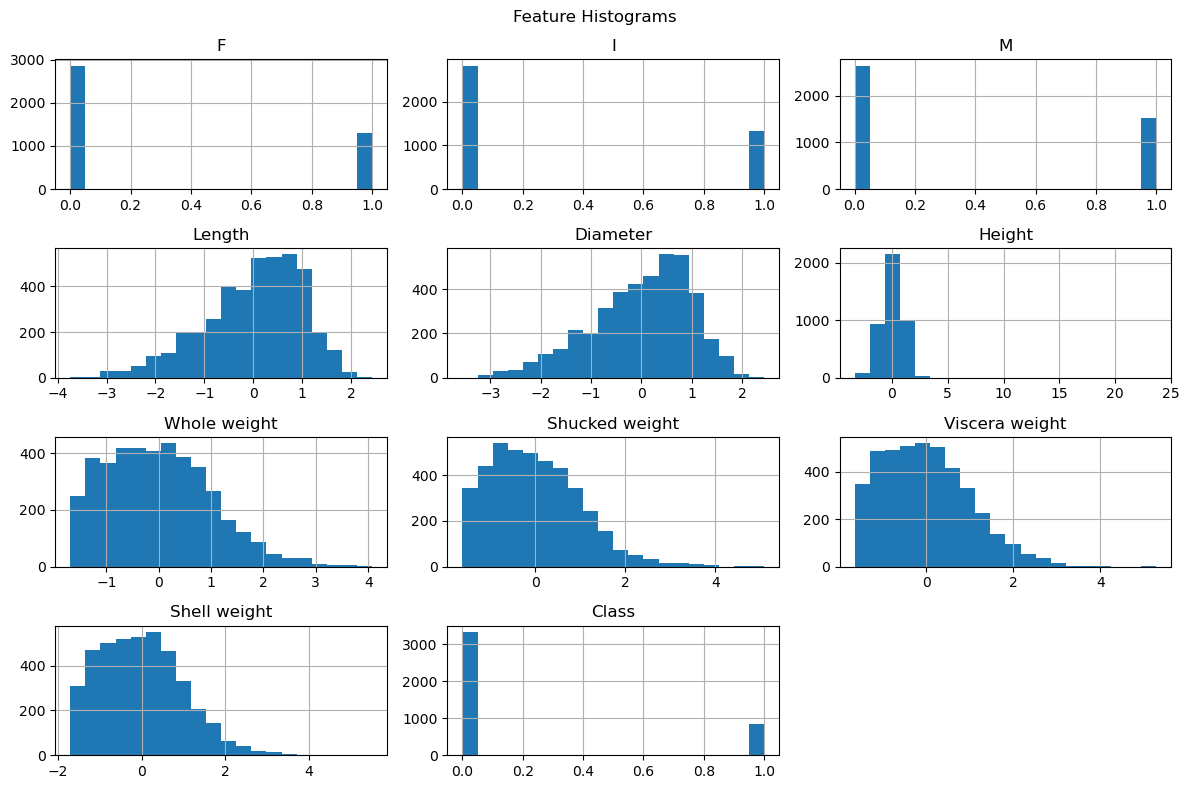

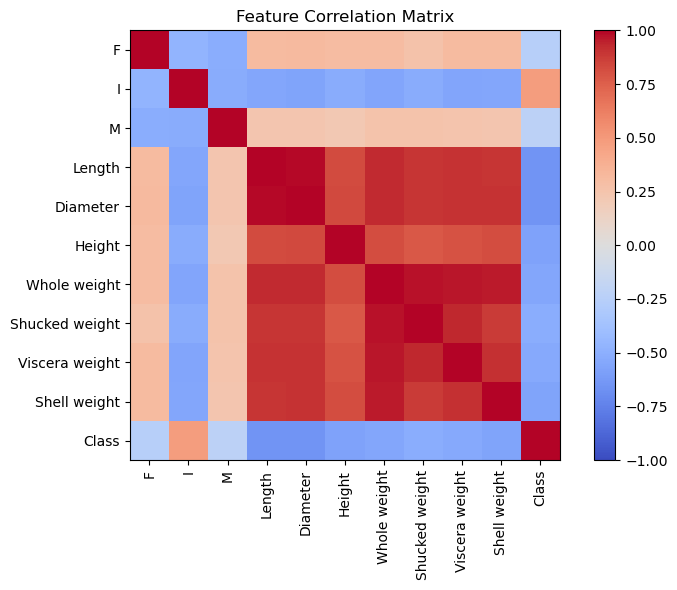

Training with SMOTE...
Training without SMOTE (Baseline)...


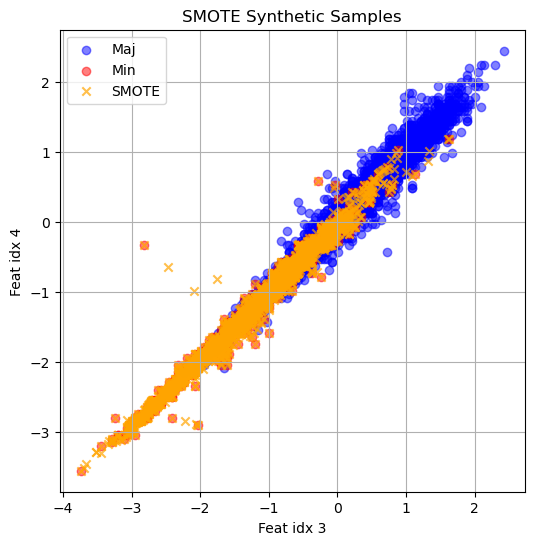

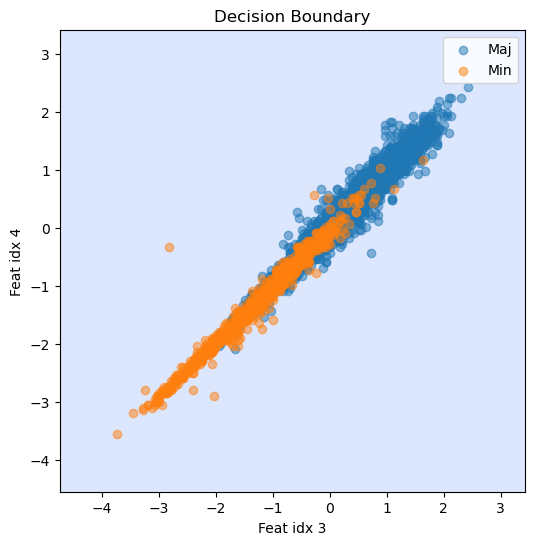

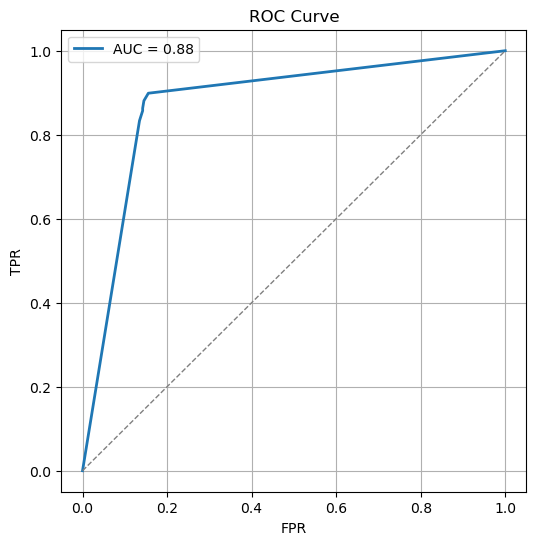

+---------------------+-----------------+--------------+-------------+---------------+----------------+-------------+------------+--------------+
| Method              |   Accuracy Mean |   AUROC Mean |   AUPR Mean |   G-mean Mean |   Accuracy STD |   AUROC STD |   AUPR STD |   G-mean STD |
+=====================+=================+==============+=============+===============+================+=============+============+==============+
| AdaBoost + SMOTE    |          0.8672 |       0.8741 |      0.5774 |        0.8696 |         0.0102 |      0.0129 |     0.0245 |       0.0114 |
+---------------------+-----------------+--------------+-------------+---------------+----------------+-------------+------------+--------------+
| Baseline (AdaBoost) |          0.9049 |       0.9389 |      0.82   |        0.8372 |         0.0083 |      0.01   |     0.0241 |       0.0178 |
+---------------------+-----------------+--------------+-------------+---------------+----------------+-------------+-------

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, roc_curve
)
from sklearn.ensemble import AdaBoostClassifier
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


# ---------------------------
# 1. بارگذاری و پیش‌پردازش دیتاست Abalone
# ---------------------------
def load_abalone_data(path):
    cols = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
            'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
    df = pd.read_csv(path, names=cols)

    # One-Hot Encode روی Sex
    ohe = OneHotEncoder(sparse_output=False)
    sex_ohe = ohe.fit_transform(df[['Sex']])
    df = df.drop('Sex', axis=1)

    # الحاق OHE با داده‌های عددی
    X = np.hstack([sex_ohe, df.drop('Rings', axis=1).values])
    feature_names = list(ohe.categories_[0]) + list(df.drop('Rings', axis=1).columns)
    data = pd.DataFrame(X, columns=feature_names)

    # باینری کردن کلاس و cast به int
    data['Class'] = (df['Rings'].astype(int) <= 7).astype(int)

    # نرمال‌سازی ویژگی‌های عددی
    scaler = StandardScaler()
    numeric_feats = data.columns[3:]  # اولین 3 ستون مربوط به OHE است
    data[numeric_feats] = scaler.fit_transform(data[numeric_feats])

    return data.drop('Class', axis=1).values, data['Class'].astype(int).values, feature_names


# ---------------------------
# 2. کاوش داده (EDA)
# ---------------------------
def explore_data(X, y, feature_names):
    df = pd.DataFrame(X, columns=feature_names)
    df['Class'] = y

    # هیستوگرام‌ها
    df.hist(bins=20, figsize=(12, 8))
    plt.suptitle("Feature Histograms")
    plt.tight_layout()
    plt.show()

    # ماتریس همبستگی
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.show()


# ---------------------------
# 3. پیاده‌سازی SMOTE (توازن کامل، λ اسکالر)
# ---------------------------
def smote(X, y, k=5):
    X_min = X[y == 1]
    X_maj = X[y == 0]
    n_min, n_maj = len(X_min), len(X_maj)
    n_syn = max(0, n_maj - n_min)
    if n_syn == 0:
        return X, y

    dists = cdist(X_min, X_min)
    nbrs = np.argsort(dists, axis=1)[:, 1:k+1]

    syn = []
    for _ in range(n_syn):
        i = np.random.randint(n_min)
        j = np.random.choice(nbrs[i])
        lam = np.random.rand()  # اسکالر
        syn.append(X_min[i] + lam * (X_min[j] - X_min[i]))

    X_syn = np.vstack(syn)
    y_syn = np.ones(len(X_syn), dtype=int)
    return np.vstack([X, X_syn]), np.hstack([y, y_syn])


# ---------------------------
# 4. Decision Stump با وزن
# ---------------------------
class DecisionStump:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None

    def fit(self, X, y, weights=None):
        if weights is None:
            weights = np.ones(len(y)) / len(y)

        best_err = float('inf')
        for f in range(X.shape[1]):
            for t in np.unique(X[:, f]):
                for pol in [1, -1]:
                    pred = (X[:, f] <= t).astype(int) if pol == 1 else (X[:, f] > t).astype(int)
                    err = np.sum(weights * (pred != y))
                    if err < best_err:
                        best_err = err
                        self.feature_idx, self.threshold, self.polarity = f, t, pol

        # وزن stump
        self.alpha = 0.5 * np.log((1 - best_err + 1e-10) / (best_err + 1e-10))
        return self

    def predict(self, X):
        if self.polarity == 1:
            return (X[:, self.feature_idx] <= self.threshold).astype(int)
        else:
            return (X[:, self.feature_idx] > self.threshold).astype(int)


# ---------------------------
# 5. AdaBoost.M1 با SMOTE (SMOTE فقط روی Train)
# ---------------------------
class AdaBoostSMOTE:
    def __init__(self, n_estimators=50, k_smote=5):
        self.n_estimators = n_estimators
        self.k_smote = k_smote
        self.alphas = []
        self.classifiers = []

    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n

        for _ in range(self.n_estimators):
            Xr, yr = smote(X, y, k=self.k_smote)  # فقط روی X_train,y_train
            stump = DecisionStump().fit(Xr, yr, weights=np.ones(len(yr)) / len(yr))
            pred = stump.predict(X)
            err = np.sum(w * (pred != y))
            if err <= 1e-10 or err >= 1 - 1e-10:
                continue
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
            w *= np.exp(-alpha * (2*pred-1) * (2*y-1))
            w /= np.sum(w)
            self.classifiers.append(stump)
            self.alphas.append(alpha)
        return self

    def predict(self, X):
        agg = sum(a * clf.predict(X) for a, clf in zip(self.alphas, self.classifiers))
        return (agg >= 0.5 * sum(self.alphas)).astype(int)

    def decision_score(self, X):
        return sum(a * clf.predict(X) for a, clf in zip(self.alphas, self.classifiers))


# ---------------------------
# 6. محاسبه G-mean
# ---------------------------
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    return tn, fp, fn, tp

def calculate_gmean(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred)
    acc_p = tp / (tp + fn) if tp+fn else 0
    acc_n = tn / (tn + fp) if tn+fp else 0
    return np.sqrt(acc_p * acc_n)


# ---------------------------
# 7. ارزیابی با CV (هر Fold مدل جدید)
# ---------------------------
def evaluate_model(model, X, y, n_splits=5, n_repeats=5):
    results = {'accuracy': [], 'auroc': [], 'aupr': [], 'gmean': []}

    for _ in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for tr, te in skf.split(X, y):
            X_tr, y_tr = X[tr], y[tr]
            X_te, y_te = X[te], y[te]

            if isinstance(model, AdaBoostSMOTE):
                m = AdaBoostSMOTE(model.n_estimators, model.k_smote)
            else:
                m = AdaBoostClassifier(n_estimators=model.n_estimators)

            m.fit(X_tr, y_tr)
            y_pred = m.predict(X_te)

            if hasattr(m, 'decision_score'):
                scores = m.decision_score(X_te)
            else:
                scores = m.predict_proba(X_te)[:, 1]

            results['accuracy'].append(accuracy_score(y_te, y_pred))
            results['auroc'].append(roc_auc_score(y_te, scores))
            results['aupr'].append(average_precision_score(y_te, scores))
            results['gmean'].append(calculate_gmean(y_te, y_pred))

    return {k: (np.mean(v), np.std(v)) for k, v in results.items()}


# ---------------------------
# 8. رسم SMOTE Samples (دو فیچر عددی)
# ---------------------------
def plot_smote_samples(X, y, feat_idxs=(3, 4)):
    plt.figure(figsize=(6, 6))
    for cls, col in zip([0, 1], ['blue', 'red']):
        plt.scatter(X[y==cls, feat_idxs[0]], X[y==cls, feat_idxs[1]],
                    label=['Maj','Min'][cls], alpha=0.5, color=col)
    Xr, yr = smote(X, y, k=5)
    plt.scatter(Xr[yr==1, feat_idxs[0]], Xr[yr==1, feat_idxs[1]],
                marker='x', label='SMOTE', alpha=0.7, color='orange')
    plt.xlabel(f"Feat idx {feat_idxs[0]}")
    plt.ylabel(f"Feat idx {feat_idxs[1]}")
    plt.title("SMOTE Synthetic Samples")
    plt.legend(); plt.grid(True); plt.show()


# ---------------------------
# 9. ترسیم Decision Boundary
# ---------------------------
def plot_decision_boundary(model, X, y, feat_idxs=(3, 4), mesh_step=0.02):
    x0, x1 = feat_idxs
    x_min, x_max = X[:,x0].min() -1, X[:,x0].max() +1
    y_min, y_max = X[:,x1].min() -1, X[:,x1].max() +1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, mesh_step),
        np.arange(y_min, y_max, mesh_step)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    full = np.zeros((grid.shape[0], X.shape[1]))
    full[:, x0] = grid[:, 0]
    full[:, x1] = grid[:, 1]

    Z = model.predict(full).reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[y==0, x0], X[y==0, x1], label='Maj', alpha=0.5)
    plt.scatter(X[y==1, x0], X[y==1, x1], label='Min', alpha=0.5)
    plt.xlabel(f"Feat idx {x0}"); plt.ylabel(f"Feat idx {x1}")
    plt.title("Decision Boundary"); plt.legend(); plt.show()


# ---------------------------
# 10. رسم ROC Curve
# ---------------------------
def plot_roc_curve(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    tr, te = next(skf.split(X, y))
    X_tr, y_tr = X[tr], y[tr]
    X_te, y_te = X[te], y[te]

    model.fit(X_tr, y_tr)
    scores = model.decision_score(X_te) if hasattr(model, 'decision_score') else model.predict_proba(X_te)[:,1]
    fpr, tpr, _ = roc_curve(y_te, scores)
    aucv = roc_auc_score(y_te, scores)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {aucv:.2f}")
    plt.plot([0,1],[0,1],'--', lw=1, color='gray')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curve'); plt.legend(); plt.grid(True); plt.show()


# ---------------------------
# 11. چاپ و ذخیره نتایج
# ---------------------------
def print_results_table(res):
    from tabulate import tabulate
    headers = ["Method","Accuracy Mean","AUROC Mean","AUPR Mean","G-mean Mean",
               "Accuracy STD","AUROC STD","AUPR STD","G-mean STD"]
    table = [[
        name,
        f"{res[name]['accuracy'][0]:.4f}",f"{res[name]['auroc'][0]:.4f}",
        f"{res[name]['aupr'][0]:.4f}",f"{res[name]['gmean'][0]:.4f}",
        f"{res[name]['accuracy'][1]:.4f}",f"{res[name]['auroc'][1]:.4f}",
        f"{res[name]['aupr'][1]:.4f}",f"{res[name]['gmean'][1]:.4f}"
    ] for name in res]
    print(tabulate(table, headers=headers, tablefmt="grid"))


def save_results_to_csv(res, fname="method_II_results.csv"):
    rows = []
    for name in res:
        a, b = res[name]['accuracy']
        u, v = res[name]['auroc']
        p, q = res[name]['aupr']
        g, h = res[name]['gmean']
        rows.append({
            "Method": name,
            "Accuracy Mean": a, "AUROC Mean": u, "AUPR Mean": p, "G-mean Mean": g,
            "Accuracy STD": b, "AUROC STD": v, "AUPR STD": q, "G-mean STD": h
        })
    pd.DataFrame(rows).to_csv(fname, index=False)
    print(f"Results saved to {fname}")


# ---------------------------
# 12. اجرای اصلی
# ---------------------------
if __name__ == "__main__":
    X, y, feat_names = load_abalone_data("abalone.data")

    # EDA
    explore_data(X, y, feat_names)

    # ارزیابی
    smote_model = AdaBoostSMOTE(n_estimators=50, k_smote=5)
    base_model = AdaBoostClassifier(n_estimators=50)

    print("Training with SMOTE...")
    res_smote = evaluate_model(smote_model, X, y)

    print("Training without SMOTE (Baseline)...")
    res_base = evaluate_model(base_model, X, y)

    # **آموزش نهایی مدل برای نمودارها**
    smote_model.fit(X, y)

    # نمودارها
    plot_smote_samples(X, y, feat_idxs=(3, 4))
    plot_decision_boundary(smote_model, X, y, feat_idxs=(3, 4))
    plot_roc_curve(smote_model, X, y)

    # نمایش و ذخیره نتایج
    results = {
        "AdaBoost + SMOTE": res_smote,
        "Baseline (AdaBoost)": res_base
    }
    print_results_table(results)
    save_results_to_csv(results)


In [4]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from tabulate import tabulate

# --------------------------------------------------
# Part A: HDDT Tree on Covid Dataset
# --------------------------------------------------

def load_covid_data(path='Covid.csv'):
    data = pd.read_csv(path)
    X = data.drop(columns=['Label'])
    y = data['Label'].apply(lambda x: 0 if x == -1 else 1)
    X = (X - X.mean()) / X.std()
    return X.values, y.values

def hellinger_distance(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2) / 2)

class HDDT:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = {}

    def _calculate_prob(self, y):
        counts = {}
        for label in y:
            counts[label] = counts.get(label, 0) + 1
        total = len(y)
        return {k: v / total for k, v in counts.items()}

    def _best_feature(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature = -1
        best_threshold = None
        p = list(self._calculate_prob(y).values())
        if len(p) < 2:
            p += [1 - p[0]]
        for feature_idx in range(n_features):
            values = X[:, feature_idx]
            unique_values = np.unique(values)
            for threshold in unique_values:
                left_mask = (values <= threshold)
                right_mask = ~left_mask
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue
                p_left = list(self._calculate_prob(y[left_mask]).values())
                p_right = list(self._calculate_prob(y[right_mask]).values())
                if len(p_left) < 2: p_left += [1 - p_left[0]]
                if len(p_right) < 2: p_right += [1 - p_right[0]]
                gain = hellinger_distance(p, p_left) + hellinger_distance(p, p_right)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]
        feature, threshold = self._best_feature(X, y)
        if feature == -1:
            return Counter(y).most_common(1)[0][0]
        left_mask = (X[:, feature] <= threshold)
        right_mask = ~left_mask
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return {'feature': feature, 'threshold': threshold,
                'left': left_subtree, 'right': right_subtree}

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature = tree['feature']
        threshold = tree['threshold']
        if x[feature] <= threshold:
            return self._predict_one(x, tree['left'])
        else:
            return self._predict_one(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true != 0) & (y_pred == 0))
    fn = np.sum((y_true == 0) & (y_pred != 0))
    tn = np.sum((y_true != 0) & (y_pred != 0))
    return np.array([[tn, fp], [fn, tp]])

def calculate_gmean(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    return np.sqrt(tpr * tnr)

def evaluate(y_true, y_pred):
    precision = np.sum((y_pred == 0) & (y_true == 0)) / np.sum(y_pred == 0) if np.sum(y_pred == 0) > 0 else 0
    recall = np.sum((y_pred == 0) & (y_true == 0)) / np.sum(y_true == 0) if np.sum(y_true == 0) > 0 else 0
    f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_true == 0, y_pred == 0)
    g_mean = calculate_gmean(y_true, y_pred)
    return precision, recall, f_measure, auc, g_mean

def run_hddt_experiment(runs=10):
    results = []
    X, y = load_covid_data()
    for _ in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
        model = HDDT(max_depth=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        p, r, f, a, g = evaluate(y_test, y_pred)
        results.append((p, r, f, a, g))
    return {
        'Precision': (np.mean([x[0] for x in results]), np.std([x[0] for x in results])),
        'Recall': (np.mean([x[1] for x in results]), np.std([x[1] for x in results])),
        'F-measure': (np.mean([x[2] for x in results]), np.std([x[2] for x in results])),
        'AUC': (np.mean([x[3] for x in results]), np.std([x[3] for x in results])),
        'G-mean': (np.mean([x[4] for x in results]), np.std([x[4] for x in results]))
    }

# --------------------------------------------------
# Part B - Method I: Bagging with Undersampling
# --------------------------------------------------

class DecisionStump:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.polarity = 1

    def fit(self, X, y):
        n_samples, n_features = X.shape
        best_error = float('inf')
        for feature_idx in range(n_features):
            unique_vals = np.unique(X[:, feature_idx])
            for threshold in unique_vals:
                for polarity in [1, -1]:
                    pred = self._predict(X, feature_idx, threshold, polarity)
                    error = np.sum(pred != y)
                    if error < best_error:
                        best_error = error
                        self.feature_idx = feature_idx
                        self.threshold = threshold
                        self.polarity = polarity
        return self

    def _predict(self, X, feature_idx, threshold, polarity):
        if polarity == 1:
            return (X[:, feature_idx] <= threshold).astype(int)
        else:
            return (X[:, feature_idx] > threshold).astype(int)

    def predict(self, X):
        return self._predict(X, self.feature_idx, self.threshold, self.polarity)

class BaggingUnderSampling:
    def __init__(self, base_learner, T):
        self.base_learner = base_learner
        self.T = T
        self.models = []

    def undersample(self, X, y):
        minority_class = 0
        majority_class = 1
        X_minority = X[y == minority_class]
        X_majority = X[y == majority_class]
        minority_sample = X_minority[np.random.choice(len(X_minority), size=len(X_minority), replace=True)]
        if len(X_majority) >= len(X_minority):
            majority_sample = X_majority[np.random.choice(len(X_majority), size=len(X_minority), replace=False)]
        else:
            majority_sample = X_majority[np.random.choice(len(X_majority), size=len(X_minority), replace=True)]
        X_resampled = np.vstack((minority_sample, majority_sample))
        y_resampled = np.concatenate([np.zeros(len(minority_sample)), np.ones(len(majority_sample))])
        return X_resampled, y_resampled

    def fit(self, X, y):
        self.models = []
        for t in range(self.T):
            X_resampled, y_resampled = self.undersample(X, y)
            model = self.base_learner()
            model.fit(X_resampled, y_resampled)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        final_prediction = np.apply_along_axis(
            lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions
        )
        return final_prediction

def run_bagging_experiment(base_learner, T_values=[11, 31, 51, 101], runs=10):
    results = {
        T: {'precision': [], 'recall': [], 'f_measure': [], 'auc': [], 'g_mean': []}
        for T in T_values
    }
    X, y = load_covid_data()
    for T in T_values:
        for run in range(runs):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
            bagging = BaggingUnderSampling(base_learner, T=T)
            bagging.fit(X_train, y_train)
            y_pred = bagging.predict(X_test)
            p, r, f, a, g = evaluate(y_test, y_pred)
            results[T]['precision'].append(p)
            results[T]['recall'].append(r)
            results[T]['f_measure'].append(f)
            results[T]['auc'].append(a)
            results[T]['g_mean'].append(g)
    return results

# --------------------------------------------------
# Part B - Method II: AdaBoost with SMOTE
# --------------------------------------------------

def load_abalone_data(path="abalone.data"):
    cols = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
            'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
    df = pd.read_csv(path, names=cols)
    ohe = OneHotEncoder(sparse_output=False)
    sex_ohe = ohe.fit_transform(df[['Sex']])
    X = df.drop('Sex', axis=1).drop('Rings', axis=1).values
    X = np.hstack([sex_ohe, X])
    y = (df['Rings'].astype(int) <= 7).astype(int)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

def smote(X, y, k=5, N=None):
    X_min = X[y == 1]
    X_maj = X[y == 0]
    n_min, n_maj = len(X_min), len(X_maj)
    if N is None:
        N = max(0, n_maj - n_min)
    if N <= 0:
        return X, y
    dists = cdist(X_min, X_min)
    nbrs = np.argsort(dists, axis=1)[:, 1:k+1]
    syn = []
    for _ in range(N):
        i = np.random.randint(n_min)
        j = np.random.choice(nbrs[i])
        lam = np.random.rand()
        syn.append(X_min[i] + lam * (X_min[j] - X_min[i]))
    X_syn = np.vstack(syn)
    y_syn = np.ones(len(X_syn), dtype=int)
    return np.vstack([X, X_syn]), np.hstack([y, y_syn])

class DecisionStumpWeighted:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None

    def fit(self, X, y, weights=None):
        if weights is None:
            weights = np.ones(len(y)) / len(y)
        best_err = float('inf')
        for f in range(X.shape[1]):
            for t in np.unique(X[:, f]):
                for pol in [1, -1]:
                    pred = (X[:, f] <= t).astype(int) if pol == 1 else (X[:, f] > t).astype(int)
                    err = np.sum(weights * (pred != y))
                    if err < best_err:
                        best_err = err
                        self.feature_idx, self.threshold, self.polarity = f, t, pol
        self.alpha = 0.5 * np.log((1 - best_err + 1e-10) / (best_err + 1e-10))
        return self

    def predict(self, X):
        if self.polarity == 1:
            return (X[:, self.feature_idx] <= self.threshold).astype(int)
        else:
            return (X[:, self.feature_idx] > self.threshold).astype(int)

class AdaBoostSMOTE:
    def __init__(self, n_estimators=50, k_smote=5):
        self.n_estimators = n_estimators
        self.k_smote = k_smote
        self.alphas = []
        self.classifiers = []

    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n
        for _ in range(self.n_estimators):
            Xr, yr = smote(X, y, k=self.k_smote)
            stump = DecisionStumpWeighted().fit(Xr, yr, weights=np.ones(len(yr)) / len(yr))
            pred = stump.predict(X)
            err = np.sum(w * (pred != y))
            if err <= 1e-10 or err >= 1 - 1e-10:
                continue
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
            w *= np.exp(-alpha * (2*pred-1) * (2*y-1))
            w /= np.sum(w)
            self.classifiers.append(stump)
            self.alphas.append(alpha)
        return self

    def predict(self, X):
        agg = sum(a * clf.predict(X) for a, clf in zip(self.alphas, self.classifiers))
        return (agg >= 0.5 * sum(self.alphas)).astype(int)

    def decision_score(self, X):
        return sum(a * clf.predict(X) for a, clf in zip(self.alphas, self.classifiers))

def evaluate_model_with_cv(model_class, X, y, n_splits=5, n_repeats=5):
    results = {'auroc': [], 'aupr': [], 'gmean': []}
    for _ in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for tr, te in skf.split(X, y):
            X_tr, y_tr = X[tr], y[tr]
            X_te, y_te = X[te], y[te]
            model = model_class()
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            scores = model.decision_score(X_te)
            results['auroc'].append(roc_auc_score(y_te, scores))
            results['aupr'].append(average_precision_score(y_te, scores))
            results['gmean'].append(calculate_gmean(y_te, y_pred))
    return {
        'auroc': (np.mean(results['auroc']), np.std(results['auroc'])),
        'aupr': (np.mean(results['aupr']), np.std(results['aupr'])),
        'gmean': (np.mean(results['gmean']), np.std(results['gmean']))
    }

# Bonus: Vary the number of synthetic samples
def evaluate_with_varied_N(model_class, X, y, N_options, n_splits=5, n_repeats=5):
    results = {}
    for N in N_options:
        print(f"Evaluating with N={N}")
        def custom_fit(X_tr, y_tr):
            Xr, yr = smote(X_tr, y_tr, N=N)
            model = model_class()
            model.fit(Xr, yr)
            return model
        aurocs, auprs, gmeans = [], [], []
        for _ in range(n_repeats):
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
            for tr, te in skf.split(X, y):
                X_tr, y_tr = X[tr], y[tr]
                X_te, y_te = X[te], y[te]
                model = custom_fit(X_tr, y_tr)
                y_pred = model.predict(X_te)
                scores = model.decision_score(X_te)
                aurocs.append(roc_auc_score(y_te, scores))
                auprs.append(average_precision_score(y_te, scores))
                gmeans.append(calculate_gmean(y_te, y_pred))
        results[f"N={N}"] = {
            'auroc': (np.mean(aurocs), np.std(aurocs)),
            'aupr': (np.mean(auprs), np.std(auprs)),
            'gmean': (np.mean(gmeans), np.std(gmeans))
        }
    return results

# --------------------------------------------------
# Main Execution
# --------------------------------------------------

if __name__ == "__main__":
    # Part A: HDDT Results
    hddt_results = run_hddt_experiment()
    print("\n=== HDDT Results ===")
    print(tabulate(hddt_results.items(), headers=["Metric", "Mean ± Std"]))

    # Part B - Method I: Bagging with Undersampling
    hddt_bagging = run_bagging_experiment(lambda: HDDT(max_depth=5))
    stump_bagging = run_bagging_experiment(lambda: DecisionStump())

    print("\n=== Bagging with HDDT ===")
    print(hddt_bagging)

    print("\n=== Bagging with Stump ===")
    print(stump_bagging)

    # Part B - Method II: AdaBoost with SMOTE
    X_abalone, y_abalone = load_abalone_data("abalone.data")
    abalone_results = evaluate_model_with_cv(lambda: AdaBoostSMOTE(n_estimators=50), X_abalone, y_abalone)
    print("\n=== AdaBoost with SMOTE on Abalone ===")
    print(abalone_results)

    # Bonus: Varying N in SMOTE
    n_min = np.sum(y_abalone == 1)
    n_maj = np.sum(y_abalone == 0)
    nmaj_nmin = n_maj - n_min
    N_options = [int(0.5 * nmaj_nmin), int(1.0 * nmaj_nmin), int(2.0 * nmaj_nmin)]
    bonus_results = evaluate_with_varied_N(lambda: AdaBoostSMOTE(n_estimators=50), X_abalone, y_abalone, N_options)
    print("\n=== Bonus Results with varying N ===")
    print(bonus_results)


=== HDDT Results ===
Metric     Mean ± Std
---------  -------------------------------------------
Precision  (0.9370270948454371, 0.0004850487678974165)
Recall     (0.9975336322869955, 0.0030824500190286008)
F-measure  (0.9663313943917566, 0.0013425752472794258)
AUC        (0.5004334828101644, 0.004066731399519959)
G-mean     (0.018175362354338625, 0.05452608706301588)

=== Bagging with HDDT ===
{11: {'precision': [0.9969135802469136, 0.9968253968253968, 0.9940298507462687, 0.9941690962099126, 0.9968652037617555, 0.9942028985507246, 0.9913294797687862, 0.9825581395348837, 0.9913294797687862, 0.9940652818991098], 'recall': [0.7242152466367713, 0.7040358744394619, 0.7466367713004485, 0.7645739910313901, 0.7130044843049327, 0.7690582959641256, 0.7690582959641256, 0.757847533632287, 0.7690582959641256, 0.7511210762331838], 'f_measure': [0.838961038961039, 0.8252299605781866, 0.852752880921895, 0.864385297845374, 0.8313725490196078, 0.8672566371681416, 0.8661616161616161, 0.855696202531645